# 3.3 Models

En esta iteración entrenamos los modelos tras gestionar el desbalanceo de los datos sin duplicados.

In [3]:
import pandas as pd
import pickle

import sys
sys.path.append("..")
from src.support_models import *

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
parametros_logistic =  [{'penalty': ['l1'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['none'], 'solver': ['lbfgs'], 'max_iter': [10000]}]

parametros_dt = {'max_depth': [4, 10, 14, 25, 40],
            'min_samples_split': [6, 8, 10, 15, 20, 25],
            'min_samples_leaf': [6, 8, 10, 15, 20, 25],
            'max_leaf_nodes': [10, 15, 20, 25, 40, 60, 90, 110]}

parametros_rf = {
            'n_estimators' : [10,20,30,40],
            'max_depth': [5, 10, 15],
            'min_samples_split': [8, 10, 15, 20],
            'min_samples_leaf': [6, 8, 10, 15, 20],
            'max_leaf_nodes': [10, 15, 20, 25]
}

parametros_gb = {
    'n_estimators': [50,100],
    'max_depth': [3,5,7],
    'min_samples_split': [3,4,7],
    'min_samples_leaf': [3,4,7],
    'max_leaf_nodes': [6,10,12]
}

parametros_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
}

parametros_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]}

In [6]:
df = pd.read_pickle("../datos/prepped_nodup.pkl")

In [7]:
df.head()

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,EducationField,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,...,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,PerformanceRating_3,PerformanceRating_4
0,0.0,0.785714,0.411411,0.000000,0.178571,0.180855,0.272843,0.154771,0.637546,0.111111,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.309524,1.000000,0.045611,0.321429,0.180855,0.559647,1.000000,0.167457,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.333333,1.000000,0.045611,0.571429,0.028357,0.459020,0.154771,0.964666,0.111111,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.476190,0.000000,0.045611,0.035714,0.180855,0.190874,0.154771,0.385045,0.333333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.333333,0.411411,0.045611,0.321429,0.163705,0.459020,1.000000,0.070195,0.444444,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


En esta parte hemos aplicado **SMOTETomek** para balancear las clases de `Attrition`. Dado que el dataset contiene variables categóricas, primero codificamos dichas columnas usando `LabelEncoder` para convertirlas en valores numéricos enteros, de forma que el algoritmo pueda procesarlas.

Es importante destacar que **SMOTETomek** no genera valores intermedios para estas categorías. La interpolación de SMOTE se aplica únicamente a variables **numéricas continuas**. Al haber codificado las categorías con valores enteros y no como `float`, garantizamos que estas variables sean tratadas como discretas y no sean interpoladas.

Finalmente, después de la resampleación, se realizó una **decodificación** para regresar los valores categóricos a su estado original, asegurando la integridad de las categorías sin introducir valores intermedios no válidos.


In [8]:
categorical_columns = df.drop(columns="Attrition").select_dtypes(include=["object", "category"]).columns
df_encoded = df.copy()

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

X = df_encoded.drop(columns="Attrition")
y = df_encoded["Attrition"]


smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

for col in categorical_columns:
    X_resampled[col] = label_encoders[col].inverse_transform(X_resampled[col])

Ahora inicializamos de nuevo el objeto sobre el que se entrenarán los modelos.

In [9]:
model_resampled = ClassificationModel(X_resampled, y_resampled)

Y ejecutamos cada uno de ellos.

In [10]:
model_resampled.train(model_type="logistic", scoring="recall", params=parametros_logistic, verbose=1)
model_resampled.train(model_type="decision_tree", scoring="recall", params=parametros_dt, verbose=1)
model_resampled.train(model_type="gradient_boosting", scoring="recall", params=parametros_gb, verbose=1)
model_resampled.train(model_type="xgboost", scoring="recall", params=parametros_xgb, verbose=1)
model_resampled.train(model_type="random_forest", scoring="recall", params=parametros_rf, verbose=1)
model_resampled.train(model_type="svc", scoring="recall", params=parametros_svc, verbose=1)

Fitting 5 folds for each of 43 candidates, totalling 215 fits
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


SVC(C=0.1, degree=2, gamma='auto', kernel='poly', random_state=42)

También obtenemos las curvas ROC.

El modelo 'svc' no soporta la función predict_proba y no se puede graficar la curva ROC.
El modelo 'svc' no soporta la función predict_proba y no se puede graficar la curva ROC.


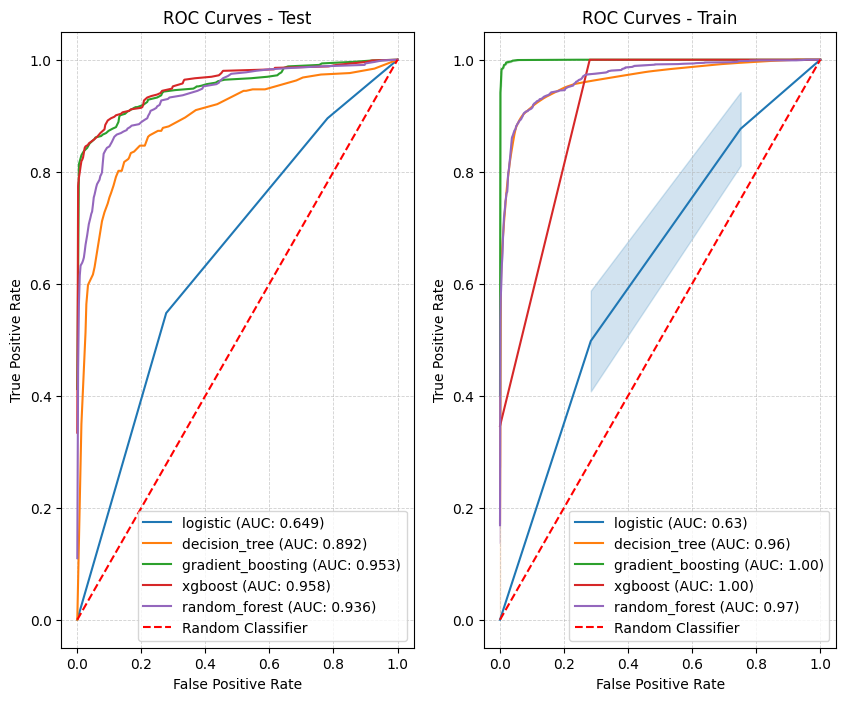

In [11]:
model_resampled.plot_roc_curves()

- **`XGBoost`** y **`Gradient Boosting`** siguen mostrando un excelente rendimiento, con valores de **AUC** muy altos tanto en **train** (`1.00`) como en **test** (`0.958` y `0.953`, respectivamente). Sin embargo, los AUC perfectos en **train** indican un posible **overfitting**, ya que los valores en **test** son ligeramente más bajos.
- **`Random Forest`** también presenta un buen AUC (`0.936` en **test**), aunque hay una notable caída respecto a su desempeño en **train** (`0.97`), lo que indica que el modelo ha perdido algo de capacidad de predicción.
- **`Logistic Regression`** y **`Decision Tree`** muestran AUCs más bajos, especialmente el **logistic** (`0.649` en **test**), lo que sugiere que estos modelos tienen más dificultad para adaptarse a la estructura de los datos tras el balanceo.

En general, el uso de **SMOTETomek** parece haber ayudado a mejorar la capacidad de los modelos para manejar el desbalanceo, como se refleja en los AUCs elevados en **test**, aunque se mantiene la preocupación de **overfitting** en los modelos más complejos. Esta mejora se puede deber a que esencialmente estamos creando los duplicados que hemos eliminado previamente. Aunque en este caso no sean duplicados como tal, son registros muy similares a los que ya encontramos en el registro, por lo que ocurre algo similar a la primera iteración, pero con un efecto más atenuado.


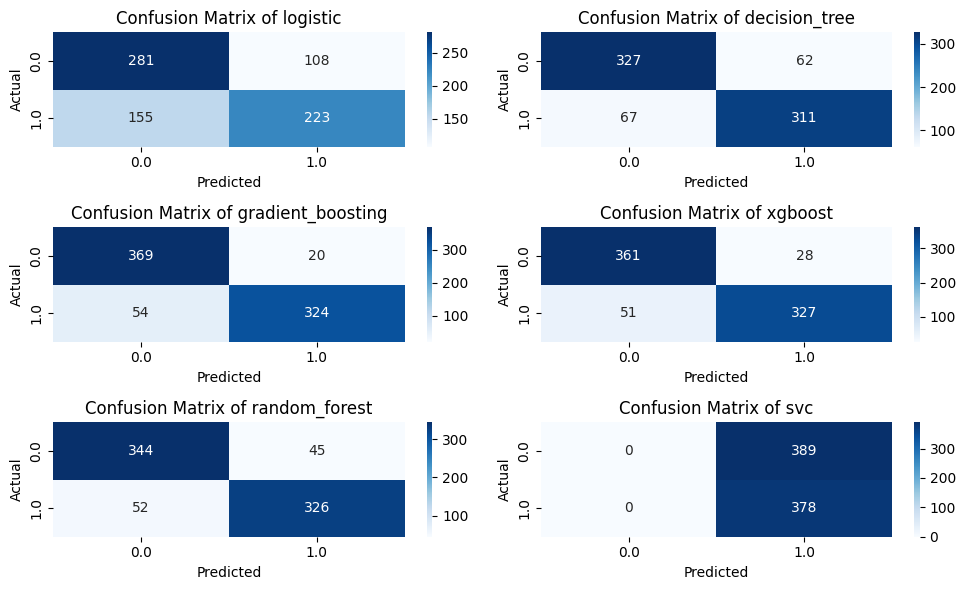

In [12]:
model_resampled.plot_confusion_matrix()

- **`XGBoost`** y **`Gradient Boosting`** presentan los mejores resultados, con un elevado número de verdaderos positivos (`XGBoost`: 327, `Gradient Boosting`: 324) y un número relativamente bajo de falsos negativos (`XGBoost`: 51, `Gradient Boosting`: 54), lo cual indica un buen **recall**. La cantidad reducida de falsos positivos en ambos modelos muestra un equilibrio entre **precisión** y **recall**.
  
- **`Random Forest`** también muestra un buen rendimiento, aunque tiene un mayor número de falsos positivos (`45`) en comparación con **`XGBoost`** y **`Gradient Boosting`**, lo cual sugiere un ligero desbalance hacia una mayor sensibilidad a la clase positiva.

- **`SVC`** presenta un caso extraño: no hay predicciones en falso. Esto indica que se ha priorizado al máximo la obtención del mayor **recall** posible, el cual se obtiene al no tener ningún registro falso, lo cual lleva al conteo de FN a 0. Evidentemente no es un resultado válido.

- **`Decision Tree`** y **`Logistic Regression`** presentan un rendimiento algo inferior. En el caso de **`Logistic Regression`**, el número de falsos negativos (`155`) y falsos positivos (`108`) es bastante elevado, lo cual indica que tiene más problemas para adaptarse a los datos balanceados y capturar correctamente la clase positiva. **`Decision Tree`** presenta un mejor balance, aunque tiene más falsos negativos (`67`) que los modelos de boosting.

En general, el uso de **SMOTETomek** ha mejorado el balance de la clase positiva, lo cual se refleja en el aumento del número de verdaderos positivos en la mayoría de los modelos, con **`XGBoost`**, **`Gradient Boosting`**, y **`SVC`** destacando como las opciones con mejor **recall**.


In [13]:
df_metrics_resampled = pd.DataFrame()
for k in model_resampled.resultados.keys():
    df_it = model_resampled.resultados[k]["metrics"]
    df_it["method"] = k
    df_metrics_resampled = pd.concat([df_metrics_resampled, df_it])

df_resultados_colores_resampled = df_metrics_resampled.copy()
df_resultados_colores_resampled.reset_index(inplace = True)
df_resultados_colores_resampled = df_resultados_colores_resampled.style.apply(color_filas_por_modelo, axis=1)
df_resultados_colores_resampled

,index,precision,accuracy,recall,f1_score,kappa,auc,time,n_jobs,method
0,train,0.656676,0.625489,0.535556,0.589963,0.251804,0.626507,0.002486,None,logistic
1,test,0.673716,0.657106,0.589947,0.629055,0.312862,0.649110,0.002486,None,logistic
2,train,0.936989,0.915595,0.892222,0.914058,0.831234,0.963763,0.003963,12,decision_tree
3,test,0.833780,0.831812,0.822751,0.828229,0.663492,0.892082,0.003963,12,decision_tree
4,train,0.996599,0.986585,0.976667,0.986532,0.973172,0.999543,0.006995,12,gradient_boosting
5,test,0.941860,0.903520,0.857143,0.897507,0.806755,0.953279,0.006995,12,gradient_boosting
6,train,1.000000,0.999441,0.998889,0.999444,0.998882,1.000000,0.020998,None,xgboost
7,test,0.921127,0.897001,0.865079,0.892224,0.793783,0.958257,0.020998,None,xgboost
8,train,0.942080,0.915036,0.885556,0.912944,0.830129,0.968773,0.037254,-1,random_forest
9,test,0.878706,0.873533,0.862434,0.870494,0.746948,0.935882,0.037254,-1,random_forest


Tras observar las métricas obtenidas, la conclusión a la que se llega es que el modelo de **`xgboost`** es el más óptimo, teniendo en cuenta su alto recall tanto en **``train``** como **``test``** (aun con un ligero overfitting), pero lo que destaca sobre el **`gradient boosting`** es la diferencia notable en rendimiento, ya que este es mucho más rápido, con unas métricas similares.

In [14]:
best_model = model_resampled.resultados["xgboost"]["mejor_modelo"]

In [15]:
best_model.fit(X,y)
y_pred = best_model.predict(X)
y_prob = best_model.predict_proba(X)[:,1]

metrics = {
            'precision' : [precision_score(y, y_pred)],
            'accuracy' : [accuracy_score(y, y_pred)],
            'recall' : [recall_score(y, y_pred)],
            'f1_score' : [f1_score(y, y_pred)],
            'kappa': [cohen_kappa_score(y, y_pred)],
            'auc': [roc_auc_score(y, y_prob)]
        }

pd.DataFrame(metrics)

,precision,accuracy,recall,f1_score,kappa,auc
0,1.0,0.999343,0.995885,0.997938,0.997547,1.0


In [16]:
with open('../models/model_resampled.pkl', 'wb') as file:
    pickle.dump(best_model, file)

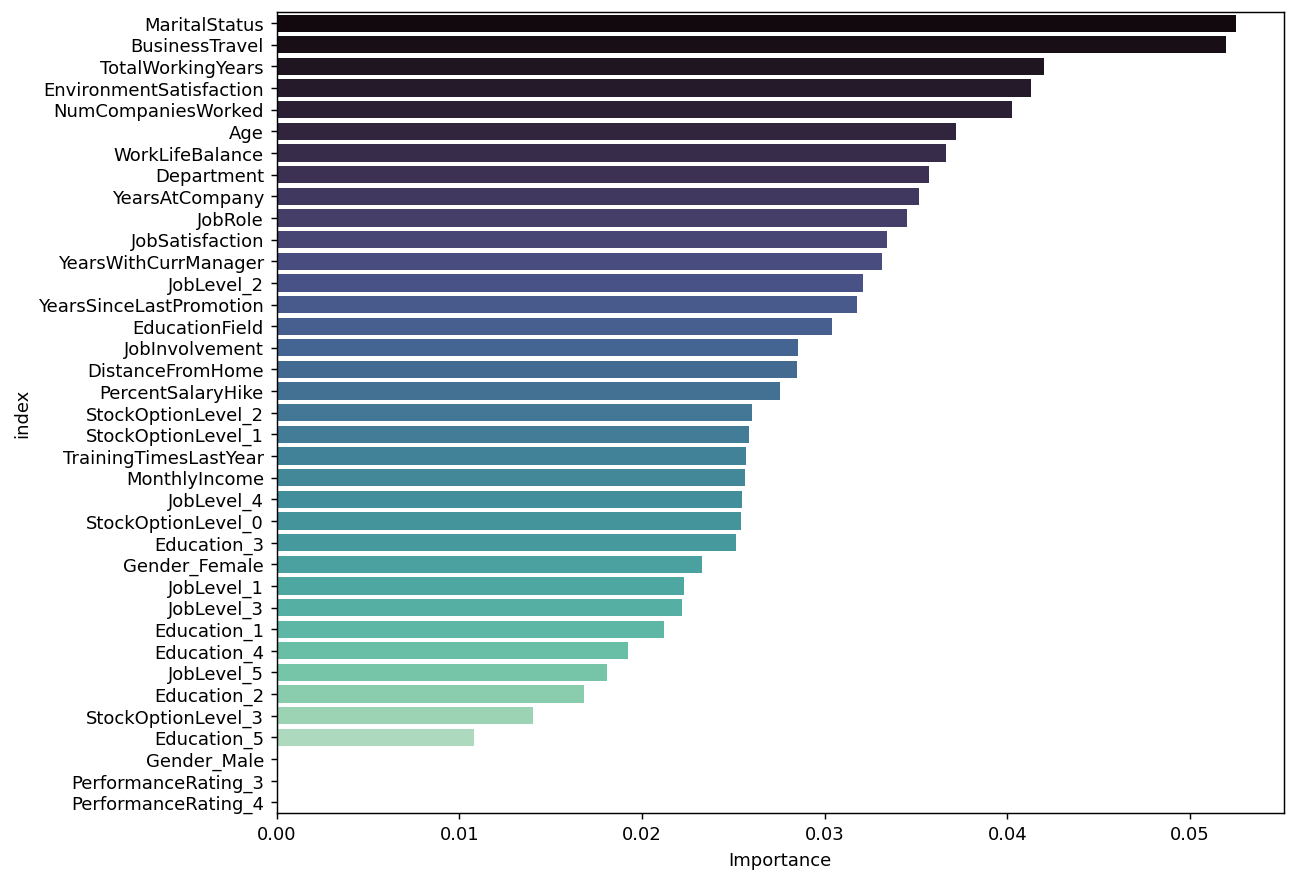

In [17]:
feature_importances = pd.DataFrame(best_model.feature_importances_,
                                    index = df.drop(columns = "Attrition").columns, 
                                    columns = ["Importance"]).sort_values(by = "Importance", ascending=False).reset_index()

plt.figure(figsize = (10,8), dpi = 130)
sns.barplot(feature_importances, y = "index", x = "Importance", palette = "mako")
plt.show()

- Las características más importantes para predecir la **attrition** son **Estado Civil (`MaritalStatus`)**, **Frecuencia de Viajes (`BusinessTravel`)**, y **Años Totales de Experiencia (`TotalWorkingYears`)**, lo que indica que factores personales, estabilidad laboral y carga de trabajo tienen un gran impacto.
- **Satisfacción con el Ambiente (`EnvironmentSatisfaction`)**, **Número de Empresas Anteriores (`NumCompaniesWorked`)**, y **Edad (`Age`)** también tienen una alta relevancia, destacando aspectos de satisfacción y trayectoria laboral.
- **Balance Vida-Trabajo (`WorkLifeBalance`)**, **Departamento (`Department`)** y **Satisfacción Laboral (`JobSatisfaction`)** son moderadamente importantes, indicando que el entorno y la satisfacción laboral juegan un papel significativo.
- **Género (`Gender`)**, **Ingresos Mensuales (`MonthlyIncome`)**, y ciertos niveles de **Educación (`Education`)** y **StockOption** tienen menor importancia, sugiriendo un impacto menos determinante en la predicción.

Esta gráfica sin embargo, no es capaz de proporcionar el sentido de esta importancia (si valores altos o bajos son los que contribuyen a una predicción de 0 o 1)

In [18]:
import shap
explainer = shap.Explainer(best_model, X)
shap_values = explainer(X)


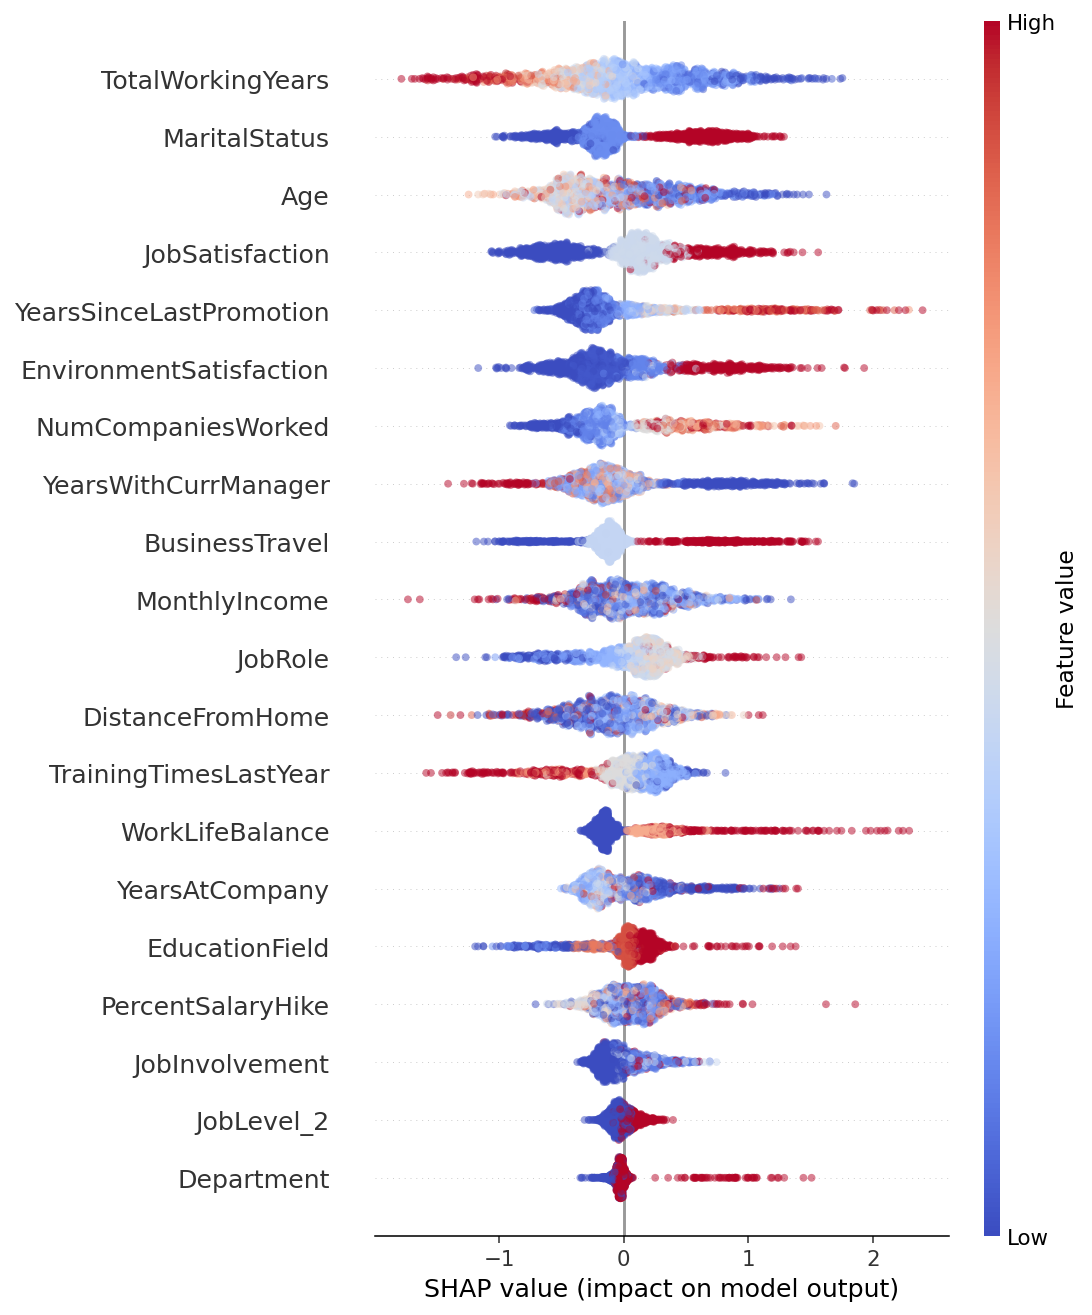

In [19]:
plt.figure(figsize=(10, 6), dpi = 140)
shap.summary_plot(shap_values, X, cmap=plt.get_cmap("coolwarm"), alpha = 0.5)
plt.show()

Este gráfico muestra un **SHAP Summary Plot** que indica cómo cada característica afecta la salida del modelo. La importancia de cada característica y su influencia se visualizan a través de los **valores SHAP**, que reflejan el impacto sobre la predicción del modelo:

- **TotalWorkingYears** es la característica más influyente, con valores altos (en rojo) que tienden a incrementar el valor de predicción del modelo, sugiriendo que una mayor experiencia laboral se asocia con una mayor probabilidad de retención.
- **MaritalStatus** también tiene un gran impacto. Los empleados casados (valores altos, en rojo) parecen estar más inclinados a permanecer en la empresa, mientras que los valores bajos están asociados con un impacto negativo en la retención.
- **Age** y **JobSatisfaction** son otras características importantes. Los empleados mayores y aquellos con una alta satisfacción laboral (en rojo) tienden a tener un impacto positivo en la retención según el modelo.
- **YearsSinceLastPromotion** demuestra que aquellos empleados que llevan más tiempo sin promocionar (rojo), son aquellos que tienden a una menor probabilidad de retención.
- **EnvironmentSatisfaction** y **NumCompaniesWorked** también afectan la predicción: altos niveles de satisfacción con el ambiente laboral (rojo) están asociados con una retención más alta, mientras que haber trabajado en muchas empresas (en azul) está relacionado con una menor estabilidad.

Otras características interesantes que influyen sobre la retención podrían ser **YearsAtCompany**, ya que no parece haber un patrón muy claro que motive a empleados más veteranos (o novatos) a marcharse de la empresa. Características puramente categóricas como pueden ser **EducationField** presentan el patrón que presentan puramente por el target encoding, donde se le asignó la tasa de retención de cada uno, por lo que es normal encontrar este ordenamiento.

In [34]:
plot_interactive_probs(y, y_prob)

Por último podemos plotear de forma interactiva nuestros datos, junto con sus probabilidades de predicción y cómo afecta el umbral de esta en valores como el recall y la especificidad. El hecho de encontrar los dos tipos de resultados en dos secciones separadas así de claramente es una buena señal de que nuestro modelo es capaz de predecir de forma correcta los valores binarios de nuestra variable respuesta.

In [33]:
y.reset_index(drop=True).to_pickle("../datos/y.pkl")
pd.Series(y_prob).to_pickle("../datos/y_prob.pkl")